In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# Load the dataset
housing = fetch_california_housing(as_frame=True)
housing_df = housing.frame  # Convert to DataFrame

# Display first few rows
housing_df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


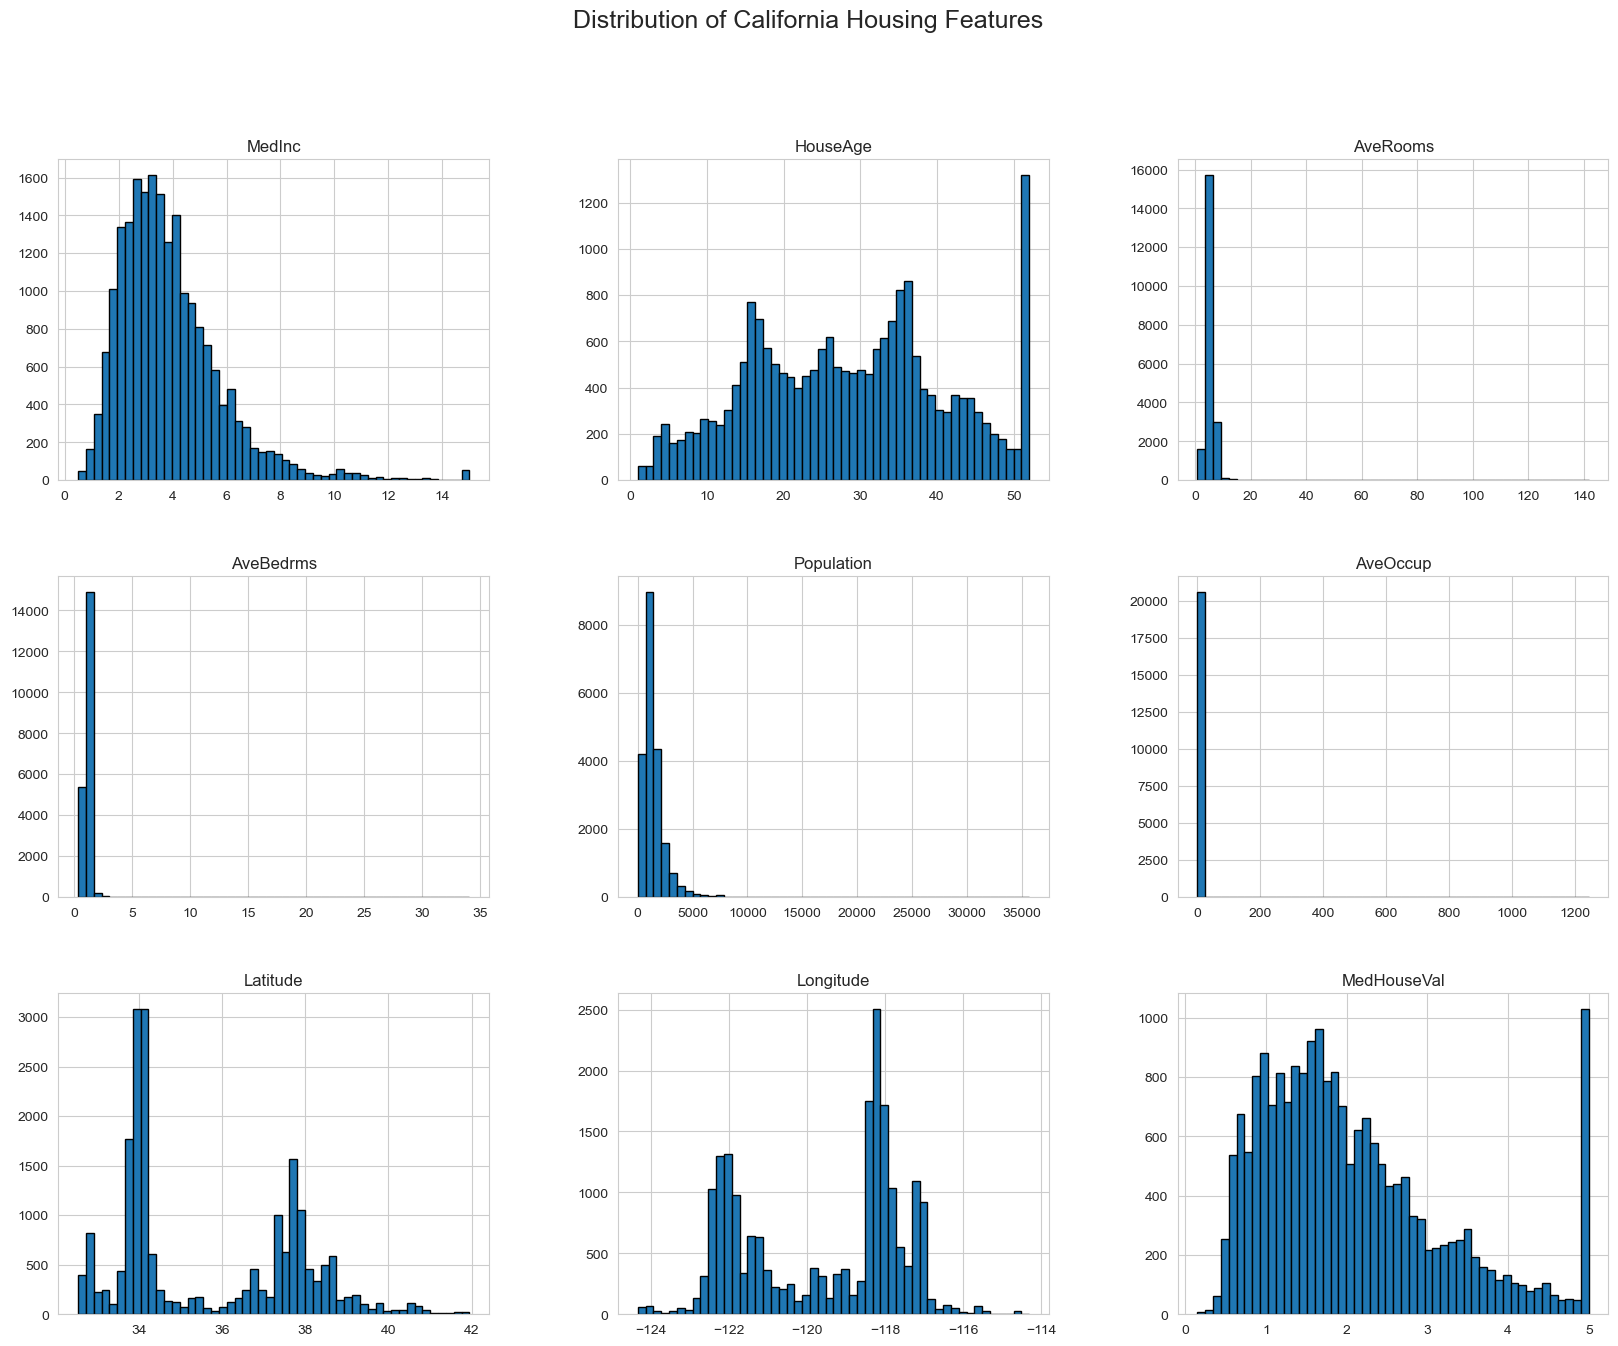

In [5]:
import seaborn as sns
sns.set_style("whitegrid")  # Set seaborn style

housing_df.hist(bins=50, figsize=(20,15), edgecolor='black')
plt.suptitle("Distribution of California Housing Features", fontsize=18)
plt.show()


The features like HouseAge, AveRooms, and Population are skewed.

MedHouseVal (median house value) is capped at 5.0, which suggests a possible ceiling effect in the data.

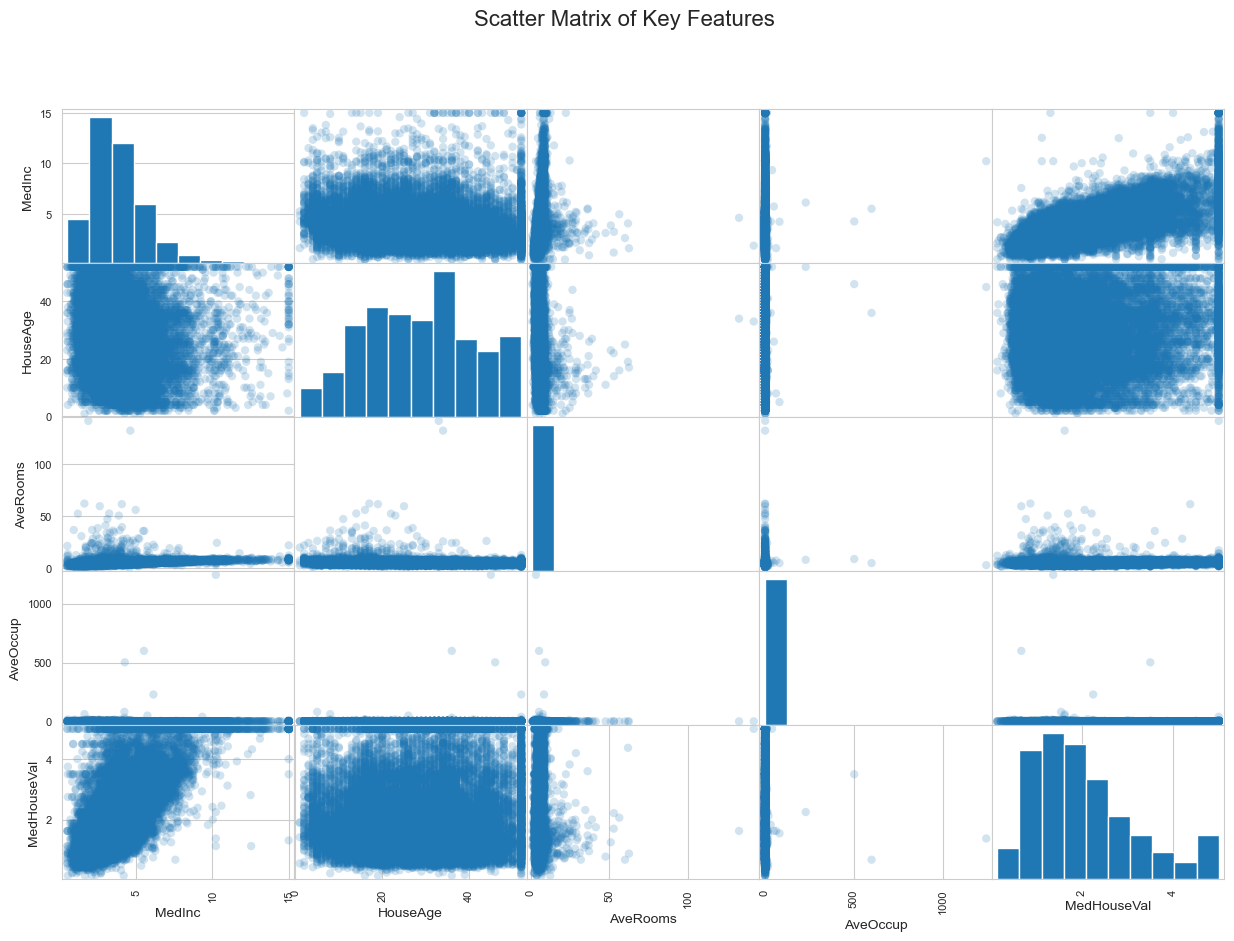

In [8]:
# Choose key attributes
key_features = ["MedInc", "HouseAge", "AveRooms", "AveOccup", "MedHouseVal"]

# Generate scatter matrix
scatter_matrix(housing_df[key_features], figsize=(15, 10), diagonal='hist', alpha=0.2, marker='o')
plt.suptitle("Scatter Matrix of Key Features", fontsize=16)
plt.show()


MedInc (median income) has the strongest positive correlation with MedHouseVal.

Some attributes (like AveOccup) might need transformation due to outliers or non-linear patterns.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Indices for AveRooms and Population
rooms_ix = list(housing_df.columns).index("AveRooms")
pop_ix = list(housing_df.columns).index("Population")

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): pass
    def fit(self, X, y=None): return self
    def transform(self, X):
        rooms_per_person = X[:, rooms_ix] / (X[:, pop_ix] + 1e-5)  # avoid divide-by-zero
        return np.c_[X, rooms_per_person]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("scaler", StandardScaler())
])
# All columns are numerical in this dataset
num_attribs = list(housing_df.drop("MedHouseVal", axis=1))  # excluding label

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing_df)

# Check the shape
housing_prepared.shape


(20640, 9)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


In [17]:
# Target variable
housing_labels = housing_df["MedHouseVal"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    housing_df.drop("MedHouseVal", axis=1), housing_labels, test_size=0.2, random_state=42)

# Preprocess training data
X_train_prepared = full_pipeline.fit_transform(X_train)

# Preprocess test data using same pipeline
X_test_prepared = full_pipeline.transform(X_test)


In [21]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=10, random_state=42)

}

# Train and evaluate
results = {}

for name, model in models.items():
    model.fit(X_train_prepared, y_train)
    preds = model.predict(X_test_prepared)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.4f}")


Linear Regression RMSE: 0.7453
Decision Tree RMSE: 0.7117
Random Forest RMSE: 0.5326


Linear Regression is your baseline.

Decision Tree will likely overfit unless regularized.

Random Forest should outperform both due to ensembling.

In [24]:
# Optional: Convert to DataFrame for nicer display
pd.DataFrame.from_dict(results, orient="index", columns=["RMSE"]).sort_values("RMSE")


,RMSE
Random Forest,0.532610
Decision Tree,0.711714
Linear Regression,0.745330


In [26]:
# Rebuild preprocessing pipeline and retrain model
final_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Full pipeline includes preprocessing
final_pipeline = Pipeline([
    ("preprocess", full_pipeline),
    ("model", final_model)
])

final_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'AveBedrms',
                                                   'Population', 'AveOccup',
                                                   'Latitude',
                                                   'Longitude'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [28]:
import joblib
joblib.dump(final_pipeline, "final_pipeline.pkl")


['final_pipeline.pkl']